In [1]:
import torch
import random
import pandas as pd
import numpy as np
import os

# 시드값 고정
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
import timm
import matplotlib.pyplot as plt

/home/yumin/miniconda3/envs/detec/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
raw_data = pd.read_csv("./dataset/sign_mnist_train.csv")
test_data = pd.read_csv("./dataset/sign_mnist_test.csv")
# raw_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/classification/data/sign_mnist_train.csv")

In [4]:
raw_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [5]:
raw_data = raw_data[:2000]

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)  # 원하는 폴드 수로 설정

labels = raw_data.iloc[:, 0]
features = raw_data

val_data = pd.DataFrame()
train_data = pd.DataFrame()

for i, (_, label_index) in enumerate( kfold.split(features, labels)):
    pic_fold_data = features.iloc[label_index]

    if not i:
        val_data = pic_fold_data.reset_index(drop=True)
        
    else:
        train_data = pd.concat([train_data, pic_fold_data], ignore_index=True)

In [6]:
transforms_for_train = A.Compose([
                A.Rotate(10),
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast()
                ])

transforms_for_test = A.Compose([
                ])

In [7]:
class Sign(Dataset):
    def __init__(self, data = None, is_train = False, transforms=None):
        self.label_data = data['label']
        self.pic_data = data.drop(labels = ["label"],axis = 1)
        self.pic_data = self.pic_data.values.reshape(-1,1, 28,28)
        self.pic_data = self.pic_data/255
        self.pic_data = torch.from_numpy(self.pic_data).float()
        self.pic_data = self.pic_data.expand(-1,3,-1,-1)
        self.is_train = is_train
        self.transforms = transforms

    def __len__(self):
        return len(self.label_data)

    def __getitem__(self, item):
        
        labels = self.label_data[item]
        images = self.pic_data[item]
        images = images.numpy()

        if self.is_train:
            images = self.transforms(image = images)['image']
        images = torch.from_numpy(images)

        return images, labels

In [8]:
train_dataset = Sign(data=train_data, is_train=True, transforms=transforms_for_train)
val_dataset = Sign(data=val_data, is_train=False)
test_dataset = Sign(data=test_data, is_train=False)

In [9]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=80,
    shuffle=True,
    num_workers=0,  # 로컬에서 작동한다면 4, 8 로 바꿔서 멀티프로세싱해도 됩니다
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=80,
    shuffle=True,
    num_workers=0,
    drop_last=True,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=80,
    shuffle=True,
    num_workers=0,
    drop_last=True,
)

In [23]:
NUM_EPOCHS = 100
VAL_EVERY = 10
SAVE_DIR = './Save/'

In [24]:
def plot_graph(loss_stack, acc_stack, lr_stack):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    epochs = range(1, len(loss_stack) + 1)
    plt.plot(epochs, loss_stack, 'b')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')

    plt.subplot(1, 3, 2)
    epochs_acc = range(1, len(acc_stack)*VAL_EVERY + 1, VAL_EVERY)
    plt.plot(epochs_acc, acc_stack, 'r')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')

    plt.subplot(1, 3, 3)
    epochs_lr = range(1, len(lr_stack) + 1)
    plt.plot(epochs_lr, lr_stack, 'g')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate')

    plt.tight_layout()
    plt.show()

In [25]:
def save_model(model, file_name='best_model_schduler2.pt'):
    output_path = os.path.join(SAVE_DIR, file_name)
    if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)
    torch.save(model, output_path)

def validation(epoch, model, data_loader, criterion):
    print(f'Start validation #{epoch:2d}')
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for step, (images, labels) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images, labels = images.cuda(), labels.cuda()
            model = model.cuda()

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        f1 = f1_score(all_labels, all_preds, average='micro')
        print(f'F1 Score: {f1}')
    return f1

def train(model, data_loader, criterion, optimizer):
    print(f'Start training..')
    acc_stack = []
    loss_stack = []
    lr_stack = []
    best_acc = 0
    
    for epoch in range(NUM_EPOCHS):
        avg_loss = 0
        total_loss = 0
        model.train()
        for step, (images, labels) in enumerate(tqdm(data_loader)):
            images, labels = images.cuda(), labels.cuda()
            model = model.cuda()

            outputs = model(images)

            loss = criterion(outputs, labels)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # step 주기에 따라 loss를 출력.
            if (step + 1) % 400 == 0:
                print(
                    f'Epoch [{epoch+1}/{NUM_EPOCHS}], '
                    f'Step [{step+1}/{len(train_loader)}], '
                    f'Loss: {round(loss.item(),4)}'
                )
        avg_loss = total_loss/len(data_loader)
        loss_stack.append(avg_loss)
        lr_stack.append(scheduler.optimizer.param_groups[0]["lr"])

        scheduler.step()
        if (epoch + 1) % VAL_EVERY == 0:
            acc = validation(epoch + 1, model, val_loader, criterion)
            acc_stack.append(acc)
            if best_acc < acc:
                print(f"Best performance at epoch: {epoch + 1}, {best_acc:.4f} -> {acc:.4f}")
                best_acc = acc
                save_model(model)
    plot_graph(loss_stack, acc_stack, lr_stack)

Start training..


100%|██████████| 20/20 [00:03<00:00,  5.71it/s]


Start validation #10


100%|██████████| 5/5 [00:00<00:00, 15.42it/s]


F1 Score: 0.7375
Best performance at epoch: 10, 0.0000 -> 0.7375


100%|██████████| 20/20 [00:03<00:00,  5.71it/s]


Start validation #20


100%|██████████| 5/5 [00:00<00:00, 15.56it/s]


F1 Score: 0.8525
Best performance at epoch: 20, 0.7375 -> 0.8525


100%|██████████| 20/20 [00:03<00:00,  5.72it/s]


Start validation #30


100%|██████████| 5/5 [00:00<00:00, 15.41it/s]


F1 Score: 0.945
Best performance at epoch: 30, 0.8525 -> 0.9450


100%|██████████| 20/20 [00:03<00:00,  5.59it/s]


Start validation #40


100%|██████████| 5/5 [00:00<00:00, 15.18it/s]


F1 Score: 0.935


100%|██████████| 20/20 [00:03<00:00,  5.61it/s]


Start validation #50


100%|██████████| 5/5 [00:00<00:00, 15.18it/s]


F1 Score: 0.9375


100%|██████████| 20/20 [00:03<00:00,  5.60it/s]


Start validation #60


100%|██████████| 5/5 [00:00<00:00, 15.18it/s]


F1 Score: 0.9425


100%|██████████| 20/20 [00:03<00:00,  5.62it/s]


Start validation #70


100%|██████████| 5/5 [00:00<00:00, 15.21it/s]


F1 Score: 0.9625
Best performance at epoch: 70, 0.9450 -> 0.9625


100%|██████████| 20/20 [00:03<00:00,  5.61it/s]


Start validation #80


100%|██████████| 5/5 [00:00<00:00, 14.17it/s]


F1 Score: 0.9625


100%|██████████| 20/20 [00:03<00:00,  5.59it/s]


Start validation #90


100%|██████████| 5/5 [00:00<00:00, 15.16it/s]


F1 Score: 0.955


100%|██████████| 20/20 [00:03<00:00,  5.61it/s]


Start validation #100


100%|██████████| 5/5 [00:00<00:00, 15.13it/s]


F1 Score: 0.9675
Best performance at epoch: 100, 0.9625 -> 0.9675


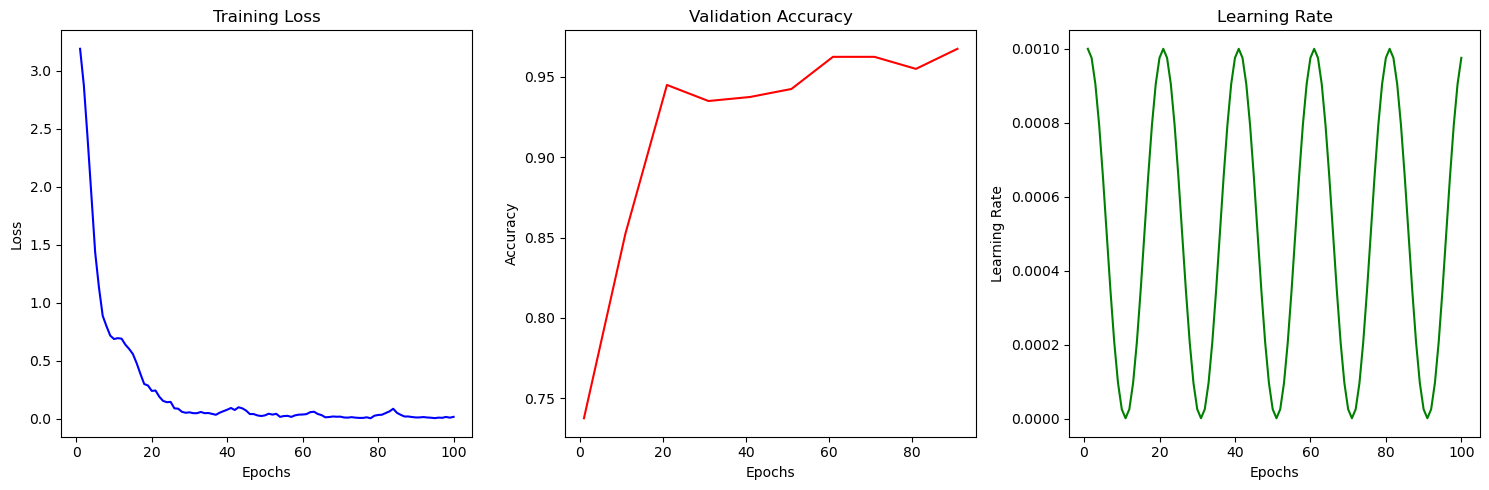

In [26]:
model = timm.create_model('resnet50', pretrained=True, num_classes=26)

criterion = nn.CrossEntropyLoss()

LR = 1e-3
optimizer = optim.AdamW(params=model.parameters(), lr=LR)

T_max = 10
scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=1e-6)

train(model, train_loader, criterion, optimizer)

In [29]:
def test(model, test_loader, criterion):
    model_path = './Save/best_model_schduler2.pt'
    model = torch.load(model_path)
    model.cuda()

    print(f'Start inference')
    model.eval()

    all_preds = []
    all_labels =[]

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        count = sum(1 for pred, label in zip(preds, labels) if pred==label)

    acc = count/len(preds)
    f1 = f1_score(all_preds, all_labels, average='micro')
    return acc, f1, all_preds, all_labels


In [30]:
criterion = nn.CrossEntropyLoss()
acc, f1, pred, gt = test(model, test_loader, criterion)

print(f'acc : {acc:.4f}')
print(f'f1 : {f1:.4f}')

Start inference


100%|██████████| 89/89 [00:05<00:00, 15.17it/s]

acc : 0.9750
f1 : 0.9694
